<a href="https://colab.research.google.com/github/aoifeoc04/PhishingDetectorModels/blob/main/Phishing_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phishing Detection Model

##1. Downloads and Imports

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.6 MB/s eta 0:00:00


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=d55eb2e8e5d7b041dab50eb4cbf5c24c1b8f43317ef2d23b7898267cf2545a59
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import os
import zipfile
import pandas as pd
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import random
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textstat import textstat
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/phishingmodel_dataset.csv'
df = pd.read_csv(file_path)

##2. Data Understanding

###2.1 Inspect Data

In [ ]:
df.head()

,text_combined,label
0,irreverent nomograph amend the only proven met...,1
1,make your rivals envy lt is really hard to rec...,1
2,copies everything - easy download or disc dupl...,1
3,re : umbrella transaction i am here ! ! ! ! ! ...,0
4,microsoft update warning - january 7 th minnes...,1


*   'text_combined' contains the email subject and body combined into one column
*   'Label' contains either 1, referring to a Phishing email, or 0, referring to a legitimate email


In [ ]:
df.shape

(37523, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37523 entries, 0 to 37522
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  37523 non-null  object
 1   label          37523 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 586.4+ KB


There is 37523 rows in the Dataset with no missing rows in either column, as shown in `df.info()`

###2.2 Check missing and duplicate values

In [ ]:
missing_values = df.isna().sum()

print(missing_values)

text_combined    0
label            0
dtype: int64


In [ ]:
df.duplicated().sum()

np.int64(0)

###2.3 Check Distribution

In [ ]:
email_counts = df['label'].value_counts()

print(email_counts)

label
1    19331
0    18192
Name: count, dtype: int64


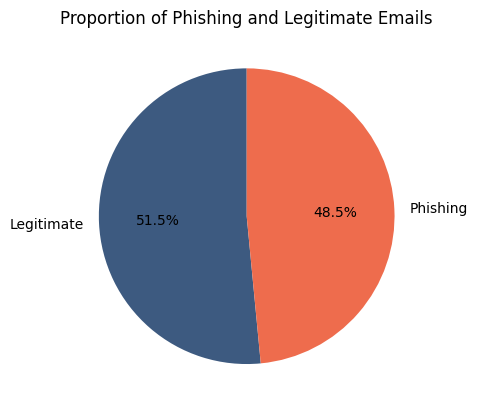

In [ ]:
email_counts.plot(kind='pie', labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', colors=['#3d5a80', '#ee6c4d'], startangle=90)

plt.title("Proportion of Phishing and Legitimate Emails")
plt.ylabel("")
plt.show()

The two classes are closely balanced which is good as problems often arise from an unbalanced class in terms of model predictions

###2.4 Check language

In [ ]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 42

def language_detect(text):
    try:
        if text and text.strip():
            return detect(text)
        else:
            return "unknown"
    except LangDetectException:
        return "unknown"

In [ ]:
df['language'] = df['text_combined'].apply(language_detect)

In [ ]:
print(df['language'].value_counts())

language
en         36788
es           144
fr           125
pt            85
ca            83
de            76
pl            36
nl            32
cy            19
tr            18
it            18
af            14
da            12
no            10
so             7
vi             6
zh-cn          6
sl             5
sv             5
unknown        4
sq             4
ja             4
ro             3
he             2
ko             2
ar             2
fi             2
tl             2
sw             2
sk             2
et             2
id             1
uk             1
cs             1
Name: count, dtype: int64


In [ ]:
df = df[df['language'] == 'en'].copy()

In [ ]:
print(df['language'].value_counts())

language
en    36788
Name: count, dtype: int64


In [ ]:
df = df.drop(columns=['language'])

##3. Raw text analysis

###3.1 Email Length

In [ ]:
df['email_length'] = df['text_combined'].apply(len)

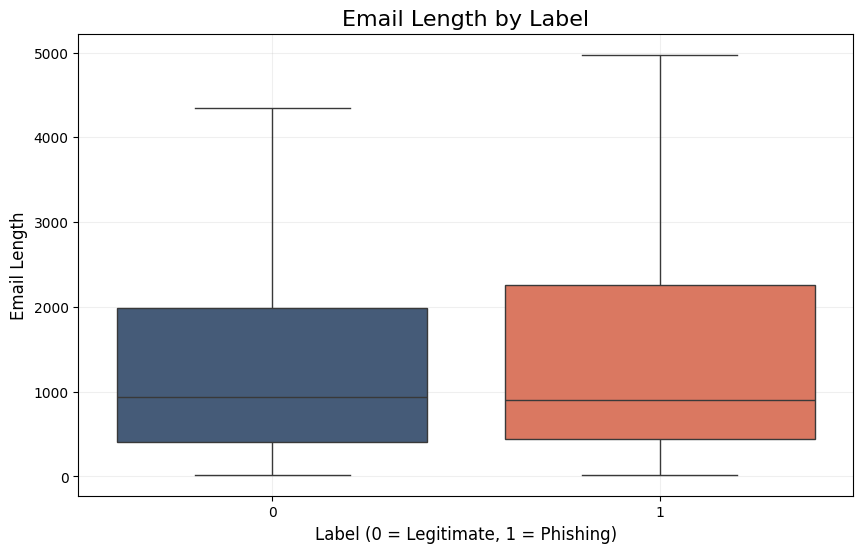

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='email_length', hue='label', data=df, palette= {0: '#3d5a80', 1: '#ee6c4d'}, showfliers=False, dodge=False)
plt.title('Email Length by Label', fontsize=16)
plt.xlabel('Label (0 = Legitimate, 1 = Phishing)', fontsize=12)
plt.ylabel('Email Length', fontsize=12)
plt.legend([],[], frameon=False)
plt.grid(alpha=0.2)
plt.show()

###3.2 Word cloud

In [ ]:
def generate_wordcloud(text, title, color = 'viridis'):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color, max_words=150).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()

In [ ]:
phishing_text = ' '.join(df[df['label'] == 1]['text_combined'])
legitimate_text = ' '.join(df[df['label'] == 0]['text_combined'])

####3.2.1 Phishing Word cloud

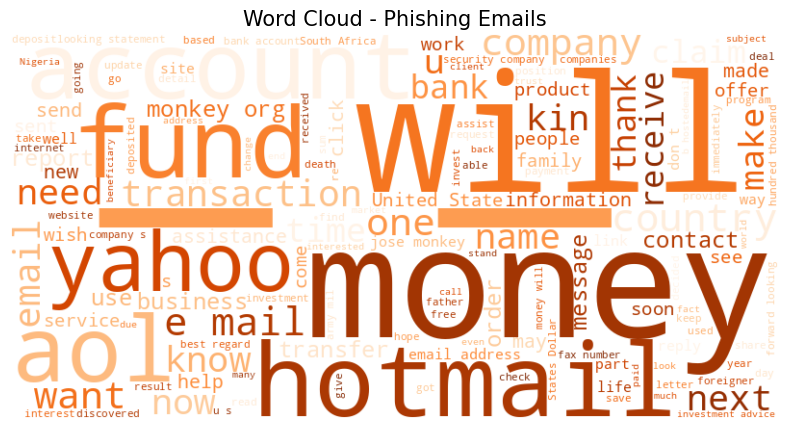

In [ ]:
generate_wordcloud(phishing_text, "Word Cloud - Phishing Emails", color='Oranges')

####3.2.2 Legitimate Word cloud

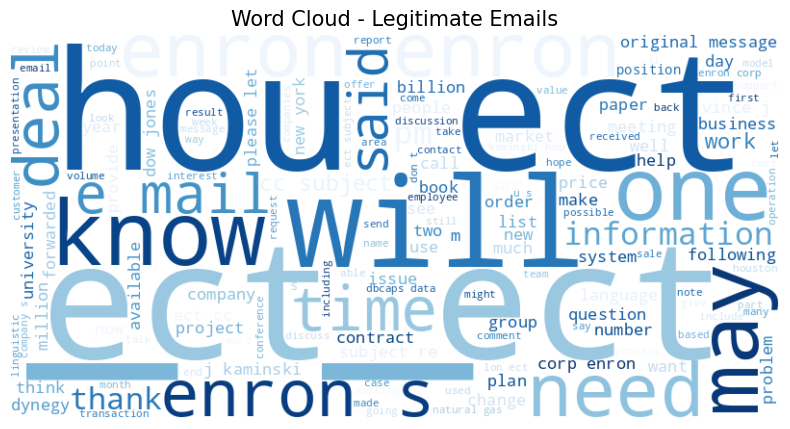

In [ ]:
generate_wordcloud(legitimate_text, "Word Cloud - Legitimate Emails", color='Blues_r')

###3.3 Most Common Words

In [ ]:
vectoriser = CountVectorizer(stop_words='english', max_features=20)

####3.3.1 Common words for Phishing

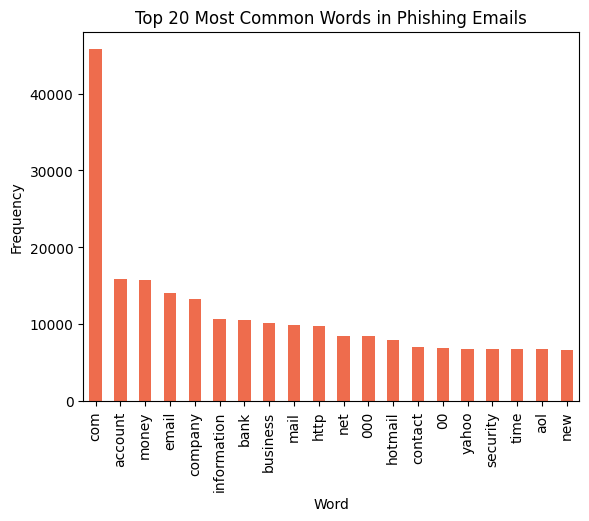

In [ ]:
common_phishing = vectoriser.fit_transform(df[df['label'] == 1]['text_combined'])

top_words_phishing = pd.DataFrame(common_phishing.toarray(), columns=vectoriser.get_feature_names_out()).sum(axis=0)
top_words_phishing = top_words_phishing.sort_values(ascending=False)

top_words_phishing.plot(kind='bar', color='#ee6c4d')
plt.title('Top 20 Most Common Words in Phishing Emails')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

####3.3.2 Common words for Legitimate

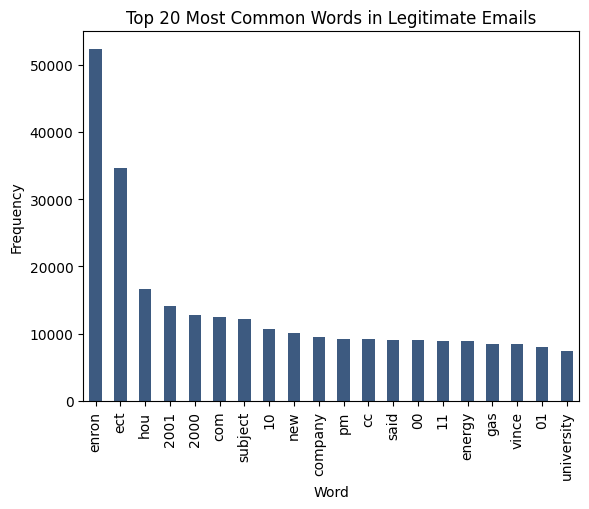

In [ ]:
common_legitimate = vectoriser.fit_transform(df[df['label'] == 0]['text_combined'])
top_words_legitimate = pd.DataFrame(common_legitimate.toarray(), columns=vectoriser.get_feature_names_out()).sum(axis=0)
top_words_legitimate = top_words_legitimate.sort_values(ascending=False)

top_words_legitimate.plot(kind='bar', color='#3d5a80')
plt.title('Top 20 Most Common Words in Legitimate Emails')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

###3.4 Sentiment Analysis

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sid = SentimentIntensityAnalyzer()

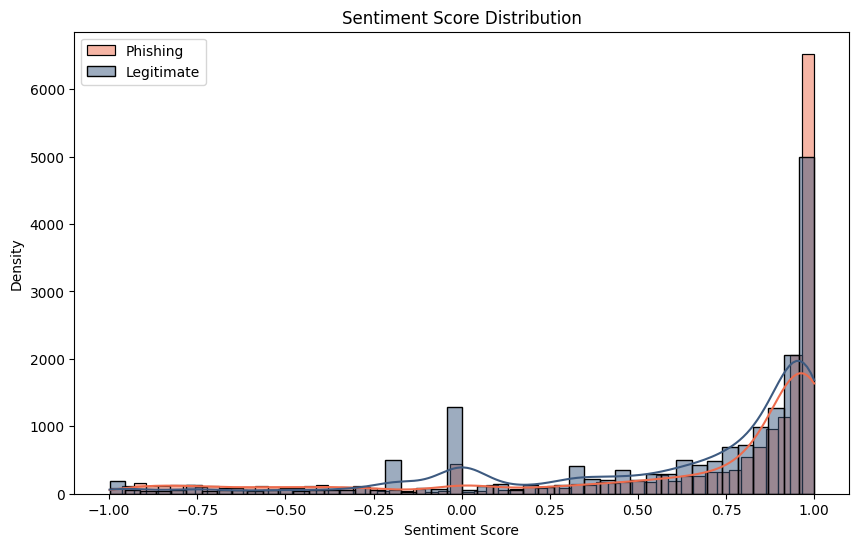

In [ ]:
def get_sentiment_score(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

df['sentiment_score'] = df['text_combined'].apply(get_sentiment_score)

plt.figure(figsize=(10, 6))
sns.histplot(df[df['label'] == 1]['sentiment_score'], color='#ee6c4d', kde=True, label='Phishing')
sns.histplot(df[df['label'] == 0]['sentiment_score'], color='#3d5a80', kde=True, label='Legitimate')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

###3.5 Readability Score

In [ ]:
df['readability_score'] = df['text_combined'].apply(lambda x: textstat.flesch_reading_ease(x))

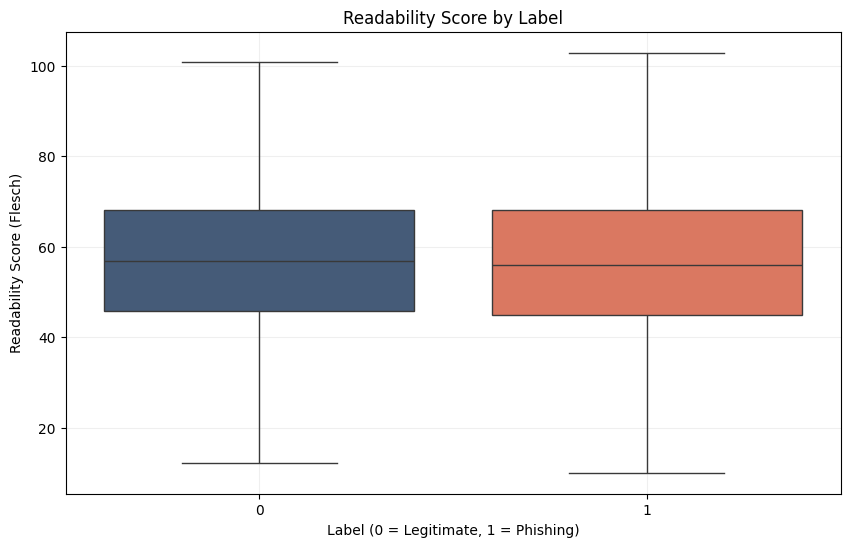

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='readability_score', hue='label', data=df, palette= {0: '#3d5a80', 1: '#ee6c4d'}, showfliers=False)

plt.title('Readability Score by Label')
plt.xlabel('Label (0 = Legitimate, 1 = Phishing)')
plt.ylabel('Readability Score (Flesch)')
plt.legend([], [], frameon=False)
plt.grid(alpha=0.2)
plt.show()

##4. Extract Raw text features

###4.1 Number of Exclamation marks

In [ ]:
df['num_exclaims'] = df['text_combined'].str.count('!')

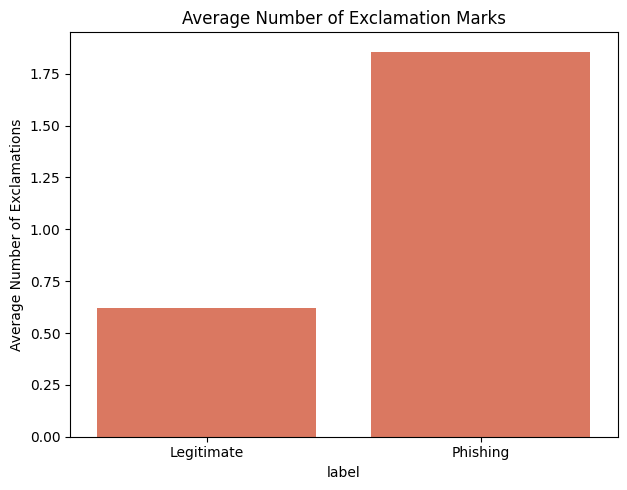

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='label', y='num_exclaims', data=df, errorbar=None, color='#ee6c4d')
plt.title('Average Number of Exclamation Marks')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.ylabel('Average Number of Exclamations')

plt.tight_layout()
plt.show()

###4.2 Number of Links

In [ ]:
df['num_links'] = df['text_combined'].str.count(r'http[s]?://')

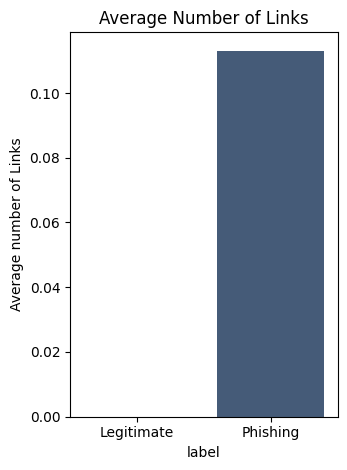

In [ ]:
plt.subplot(1, 2, 2)
sns.barplot(x='label', y='num_links', data=df, errorbar=None, color='#3d5a80')
plt.title('Average Number of Links')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.ylabel('Average number of Links')

plt.tight_layout()
plt.show()

##5. Pre-process text

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

In [ ]:
df['clean_text'] = df['text_combined'].apply(preprocess)

##6. Clean text Feature Engineering

###6.1 N-grams

In [ ]:
phishing_df = df[df['label'] == 1]['clean_text']
legitimate_df = df[df['label'] == 0]['clean_text']

####6.1.1 Phishing and Legitimate N-grams

In [ ]:
def get_ngrams(texts, ngram_range=(2, 3), top_n=20):
    vectoriser = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    X = vectoriser.fit_transform(texts)
    sum = X.sum(axis=0)

    ngrams = [(word, sum[0, idx]) for word, idx in vectoriser.vocabulary_.items()]
    ngrams = sorted(ngrams, key=lambda x: x[1], reverse=True)

    return pd.DataFrame(ngrams[:top_n], columns=['ngram', 'frequency'])

In [ ]:
top_phishing_phrases = get_ngrams(phishing_df, ngram_range=(2,3), top_n=20)
top_legitimate_phrases = get_ngrams(legitimate_df, ngram_range=(2,3), top_n=20)

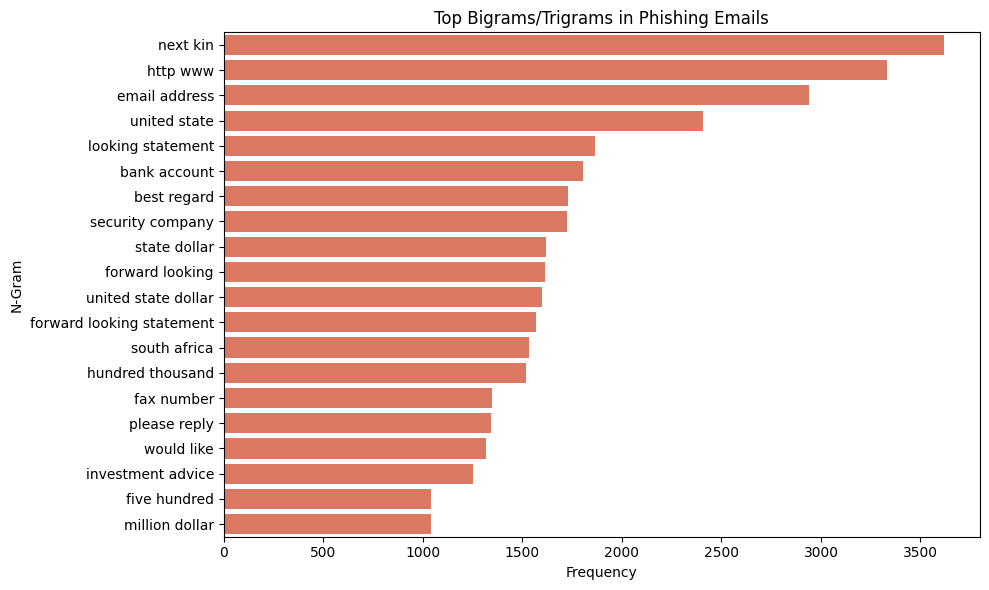

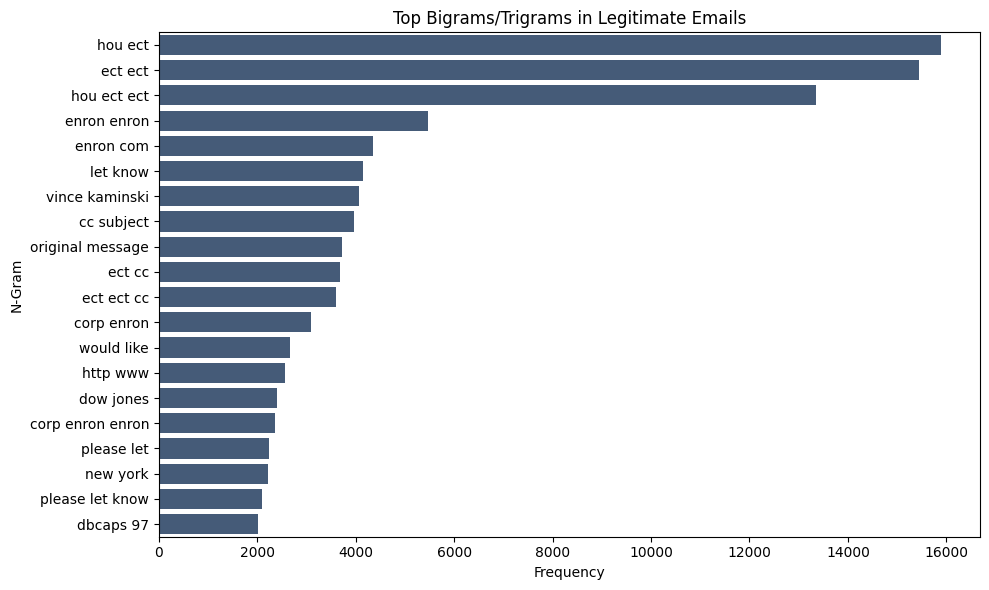

In [ ]:
def plot_ngrams(df, title, color):
    plt.figure(figsize=(10,6))
    sns.barplot(x='frequency', y='ngram', data=df, color=color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('N-Gram')
    plt.tight_layout()
    plt.show()

plot_ngrams(top_phishing_phrases, "Top Bigrams/Trigrams in Phishing Emails", '#ee6c4d')
plot_ngrams(top_legitimate_phrases, "Top Bigrams/Trigrams in Legitimate Emails", '#3d5a80')

###6.2 Keyword Flags

In [ ]:
phishing_keywords = ['next kin', 'looking statement', 'hundred thousand',
                     'forward looking', 'investment advice','please reply']

for kw in phishing_keywords:
    df[f'kw_{kw}'] = df['clean_text'].apply(lambda x: int(kw in x))

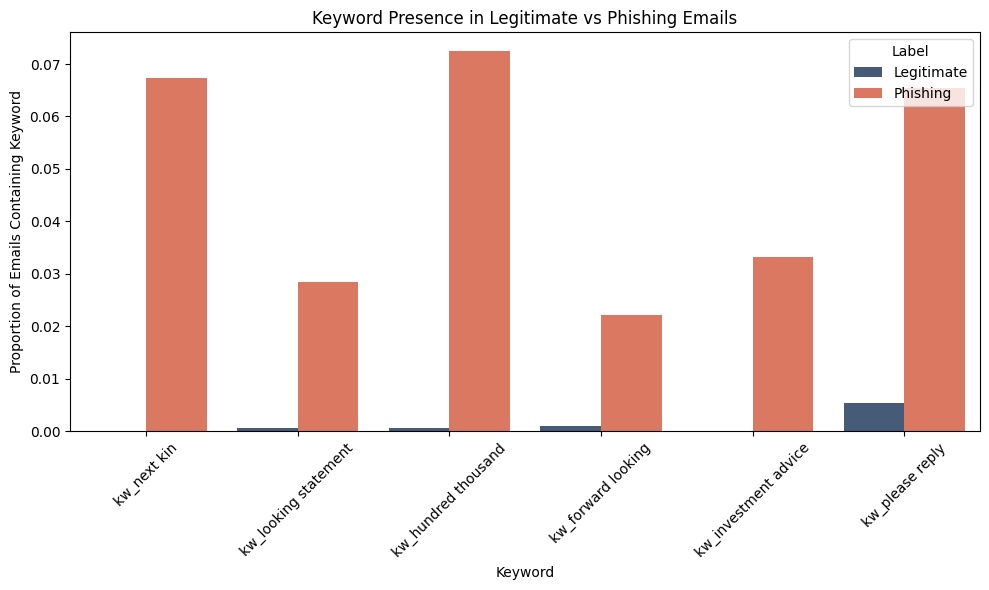

In [ ]:
keyword_column = [f'kw_{kw}' for kw in phishing_keywords]
keyword_sums = df.groupby('label')[keyword_column].mean().T

keyword_sums.reset_index(inplace=True)
keyword_sums = keyword_sums.rename(columns={0: 'Legitimate', 1: 'Phishing'})
keyword_data = keyword_sums.melt(id_vars='index', var_name='Label', value_name='Proportion')
keyword_data = keyword_data.rename(columns={'index': 'Keyword'})

plt.figure(figsize=(10, 6))
sns.barplot(x='Keyword', y='Proportion', hue='Label', data=keyword_data, palette=['#3d5a80', '#ee6c4d'])

plt.ylabel('Proportion of Emails Containing Keyword')
plt.title('Keyword Presence in Legitimate vs Phishing Emails')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###6.3 Final Dataset

In [ ]:
df.head()

,text_combined,label,email_length,sentiment_score,readability_score,num_exclaims,num_links,clean_text,kw_next kin,kw_looking statement,kw_hundred thousand,kw_forward looking,kw_investment advice,kw_please reply
0,irreverent nomograph amend the only proven met...,1,2268,-0.7156,-13.57,4,0,irreverent nomograph amend proven metfhod enhw...,0,0,0,0,0,0
1,make your rivals envy lt is really hard to rec...,1,1445,0.9868,47.35,0,0,make rival envy lt really hard recollect compa...,0,0,0,0,0,0
2,copies everything - easy download or disc dupl...,1,309,0.7579,70.13,0,0,copy everything easy download disc duplicator ...,0,0,0,0,0,0
3,re : umbrella transaction i am here ! ! ! ! ! ...,0,956,0.7067,45.86,39,0,umbrella transaction original message schoppe ...,0,0,0,0,0,0
4,microsoft update warning - january 7 th minnes...,1,2949,-0.9981,43.53,0,0,microsoft update warning january 7 th minnesot...,0,0,0,0,0,0


##7. TF-IDF with N-gram range

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X = vectoriser.fit_transform(df['clean_text'])

In [ ]:
from scipy.sparse import hstack

extra_features = df[[
    'sentiment_score', 'num_exclaims',
    'num_links',
    'kw_next kin', 'kw_looking statement', 'kw_hundred thousand', 'kw_forward looking', 'kw_investment advice', 'kw_please reply'
]].values

X = hstack([X, extra_features])

##8. Define target column

In [ ]:
y = df['label']

##9. Train and Evaluate models

###9.1 Train models

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [ ]:
phishing_emails = y_test == 1
legitimate_emails = y_test == 0

X_test = X_test.toarray()
phishing_rows = X_test[phishing_emails]
legitimate_rows = X_test[legitimate_emails]

In [ ]:
from sklearn.metrics import classification_report
from scipy.sparse import hstack, issparse
from sklearn.metrics import f1_score

for name, model in models.items():
    if name == "XGBoost":
        X_train_model = X_train.toarray() if issparse(X_train) else X_train
        X_test_model = X_test.toarray() if issparse(X_test) else X_test
    else:
        X_train_model = X_train
        X_test_model = X_test

    model.fit(X_train_model, y_train)
    y_pred = model.predict(X_test_model)

    phishing_probs = model.predict_proba(phishing_rows)[:, 1]
    legitimate_probs = model.predict_proba(legitimate_rows)[:, 1]
    f1 = f1_score(y_test, y_pred)

    print(f"\n {name} ")
    print(f"F1 Score:  {f1:.5f}")
    print(classification_report(y_test, y_pred, target_names=["Legitimate", "Phishing"]))
    print(f"Average phishing probability in Phishing emails:  {phishing_probs.mean():.3f}")
    print(f"Average phishing probability in Legitimate emails:     {legitimate_probs.mean():.3f}")


Model: Logistic Regression 
F1 Score:  0.98586
              precision    recall  f1-score   support

  Legitimate       0.99      0.98      0.99      3596
    Phishing       0.98      0.99      0.99      3762

    accuracy                           0.99      7358
   macro avg       0.99      0.99      0.99      7358
weighted avg       0.99      0.99      0.99      7358

Average phishing probability in Phishing emails:  0.944
Average phishing probability in Legitimate emails:     0.060

Model: Random Forest 
F1 Score:  0.98411
              precision    recall  f1-score   support

  Legitimate       0.99      0.98      0.98      3596
    Phishing       0.98      0.99      0.98      3762

    accuracy                           0.98      7358
   macro avg       0.98      0.98      0.98      7358
weighted avg       0.98      0.98      0.98      7358

Average phishing probability in Phishing emails:  0.917
Average phishing probability in Legitimate emails:     0.091


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:03:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost 
F1 Score:  0.98301
              precision    recall  f1-score   support

  Legitimate       0.99      0.97      0.98      3596
    Phishing       0.97      0.99      0.98      3762

    accuracy                           0.98      7358
   macro avg       0.98      0.98      0.98      7358
weighted avg       0.98      0.98      0.98      7358

Average phishing probability in Phishing emails:  0.959
Average phishing probability in Legitimate emails:     0.045


###9.2 Visualisations

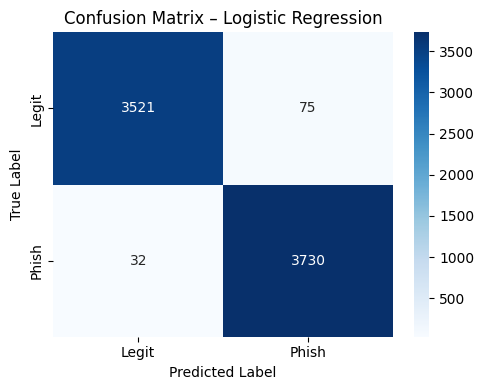

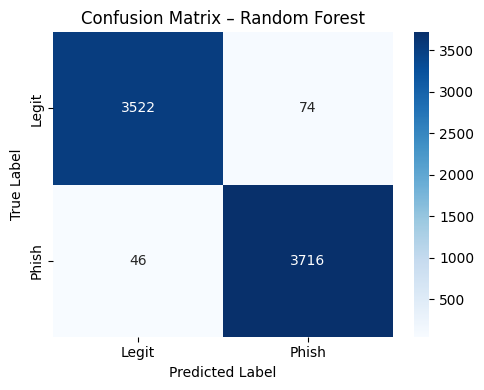

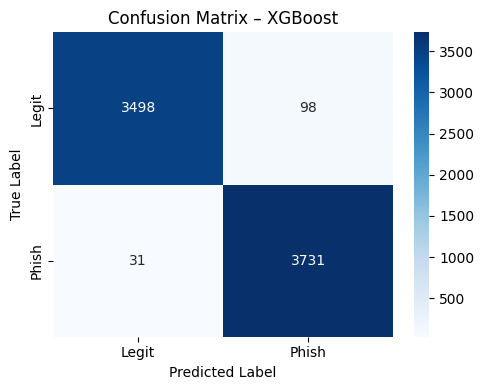

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Legit", "Phish"],
                yticklabels=["Legit", "Phish"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


##10. Hypertune Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=1000)

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
}

lr_grid = GridSearchCV(lr, lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best Logistic Regression Params:", lr_grid.best_params_)
print("Best F1 Score:", lr_grid.best_score_)

Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 Score: 0.987906369985039


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

rf_grid.fit(X_train, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)
print("Best F1 Score:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Random Forest Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 Score: 0.9860499906337715


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

xgb_param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5,],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

xgb_random = RandomizedSearchCV( xgb, param_distributions=xgb_param_dist, n_iter=20, scoring='f1', cv=5, verbose=1, n_jobs=-1, random_state=42)

xgb_random.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_random.best_params_)
print("Best F1 Score:", xgb_random.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:45:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best F1 Score: 0.976161278666998


In [ ]:
best_lr = lr_grid.best_estimator_

##11. Ensemble Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

lr_probs = best_lr.predict_proba(X_test)[:, 1]
xgb_probs = models["XGBoost"].predict_proba(X_test)[:, 1]

ensemble_probs = (0.7 * lr_probs + 0.3 * xgb_probs)
ensemble_predict = (ensemble_probs >= 0.6).astype(int)

f1 = f1_score(y_test, ensemble_predict)

phishing_probs = ensemble_probs[y_test == 1]
legitimate_probs = ensemble_probs[y_test == 0]

print(f"F1 Score:    {f1:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, ensemble_predict, target_names=["Legitimate", "Phishing"]))

print(f"\n Average phishing prob on Phishing emails:  {phishing_probs.mean():.3f}")
print(f"Average phishing prob on Legitimate emails:     {legitimate_probs.mean():.3f}")

F1 Score:    0.989102

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      3596
    Phishing       0.99      0.99      0.99      3762

    accuracy                           0.99      7358
   macro avg       0.99      0.99      0.99      7358
weighted avg       0.99      0.99      0.99      7358


 Average phishing prob on Phishing emails:  0.969
Average phishing prob on Legitimate emails:     0.034


##13. Final model

In [ ]:
import pickle

ensemble_package = {
    "best_lr": best_lr,
    "xgboost": models["XGBoost"],
    "weights": {"best_lr": 0.8, "xgboost": 0.2},
    "threshold": 0.6
}

with open('phishing_email_model.pkl', 'wb') as file:
    pickle.dump(ensemble_package, file)

print("Model saved")

Model saved


In [ ]:
from google.colab import files
files.download('phishing_email_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

joblib.dump(vectoriser, "phishing_email_vectoriser.pkl")
print("Vectoriser saved")

Vectoriser saved


In [ ]:
from google.colab import files
files.download("phishing_email_vectoriser.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##14. Test on AI-generated Phishing emails

In [160]:
import pandas as pd

file_path_AI = '/content/drive/MyDrive/ai_phishing_dataset.csv'
df_AI = pd.read_csv(file_path_AI)

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
import joblib

model = joblib.load("phishing_email_model.pkl")
vectoriser = joblib.load("phishing_email_vectoriser.pkl")

###14.1 Inspect Dataset

In [161]:
df_AI.head()

,label,email_subject,email_body,text_combined
0,0,Limited-Time Offer: Review Your Bonus,"Dear Valued Member,\n\nYou’re eligible for a n...",Limited-Time Offer: Review Your Bonus\n\nDear ...
1,0,Limited-Time Offer: Review Your Bonus,"Dear Valued Member,\n\nYou’re eligible for a n...",Limited-Time Offer: Review Your Bonus\n\nDear ...
2,0,Team Briefing: Upcoming Training,"Dear All,\n\nAs part of our regular update cyc...","Team Briefing: Upcoming Training\n\nDear All,\..."
3,0,Team Briefing: Budget Review,"Dear All,\n\nAs part of our regular update cyc...","Team Briefing: Budget Review\n\nDear All,\n\nA..."
4,0,Limited-Time Offer: Review Your Account Status,"Dear Valued Member,\n\nYou’re eligible for a n...",Limited-Time Offer: Review Your Account Status...


In [162]:
df_AI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          450 non-null    int64 
 1   email_subject  450 non-null    object
 2   email_body     450 non-null    object
 3   text_combined  450 non-null    object
dtypes: int64(1), object(3)
memory usage: 14.2+ KB


###14.2 Preprocess

In [163]:
df_AI['clean_text'] = df_AI['text_combined'].apply(preprocess)

In [164]:
df_AI['sentiment_score'] = df_AI['text_combined'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [165]:
df_AI['num_exclaims'] = df_AI['text_combined'].str.count('!')
df_AI['num_links'] = df_AI['text_combined'].str.count('http')

In [166]:
keywords = ['next kin', 'looking statement', 'hundred thousand',
            'forward looking', 'investment advice', 'please reply']

for kw in keywords:
    kw_col = f'kw_{kw}'
    df_AI[kw_col] = df_AI['clean_text'].str.contains(kw.replace(" ", ""), case=False).astype(int)

In [167]:
X_text = vectoriser.transform(df_AI['clean_text'])

In [168]:
from scipy.sparse import hstack

extra_features = df_AI[[
    'sentiment_score', 'num_exclaims', 'num_links'
] + [f'kw_{kw}' for kw in keywords]].values

X = hstack([X_text, extra_features])

###14.3 Evaluate on Test dataset

In [169]:
def ensemble_predict(model_dict, features, threshold=0.6):
    lr_probs = model_dict['best_lr'].predict_proba(features)[:, 1]
    xgb_probs = model_dict['xgboost'].predict_proba(features)[:, 1]

    final_probs = 0.7 * lr_probs + 0.3 * xgb_probs

    predictions = (final_probs >= threshold).astype(int)

    return final_probs, predictions

In [170]:
probs, preds = ensemble_predict(model, X)

In [171]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_true = df_AI['label']

f1 = f1_score(y_true, preds)
print(f"F1 Score: {f1:.3f}")

print(classification_report(y_true, preds))

print(f"Average phishing prob on Phishing emails:  {probs[y_true == 1].mean():.3f}")
print(f"Average phishing prob on Legitimate emails:     {probs[y_true == 0].mean():.3f}")

F1 Score: 0.889
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       250
           1       0.80      1.00      0.89       200

    accuracy                           0.89       450
   macro avg       0.90      0.90      0.89       450
weighted avg       0.91      0.89      0.89       450

Average phishing prob on Phishing emails:  0.764
Average phishing prob on Legitimate emails:     0.240


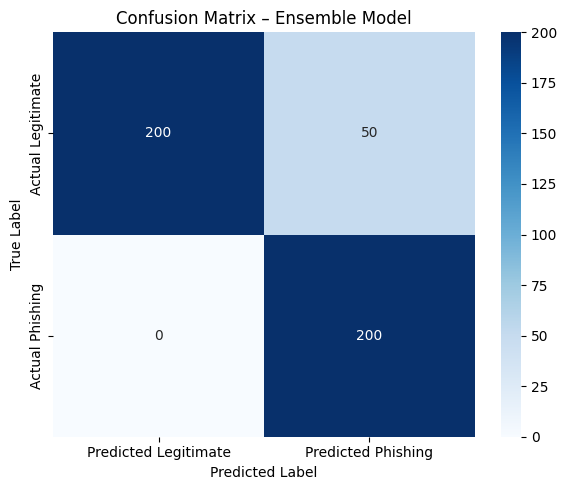

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=["Predicted Legitimate", "Predicted Phishing"],
            yticklabels=["Actual Legitimate", "Actual Phishing"])

plt.title("Confusion Matrix – Ensemble Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()